In [1]:
import sys
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
# Start by loading the data

training_path = "CinC2017Data/training2017/training2017/"
answers_path = "CinC2017Data/REFERENCE-v3.csv"

dataset = pd.read_csv(answers_path, header=None, names=["class"], index_col=0)
dataset["data"] = None

print(dataset.head())

for root, dirs, files in os.walk(training_path):
    for name in files:
        try:
            name, ext = name.split(".")
        except ValueError:
            print("error, scipping file")
            continue
        if ext == "mat":
            mat_data = scipy.io.loadmat(os.path.join(root, name+"."+ext))
            dataset.loc[name]["data"] = mat_data["val"]
            print(f"Adding {name}\r", end="")

print(dataset.head())
pk_path = "CinC2017Data/database.pk"
dataset.to_pickle(pk_path)

In [2]:
dataset = pd.read_pickle("CinC2017Data/database.pk")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [19]:
def get_power_ratios(data):
    N = data.shape[-1]
    fft = np.fft.fft(data[0])
    fftfreq = np.fft.fftfreq(data.shape[-1], 1/300.0)

    fft_low_freq = fft[fftfreq < 5]
    fft_med_freq = fft[np.logical_and(fftfreq > 5, fftfreq < 40)]
    fft_high_freq = fft[fftfreq > 40]

    total_power = 1/N * np.sum(np.abs(fft) ** 2)

    return np.array([((1/f.shape[0]) * np.sum(np.abs(f) ** 2))/total_power for f in (fft_low_freq, fft_med_freq, fft_high_freq)])


dataset["mean"] = dataset["data"].map(np.mean)
dataset["std_dev"] = dataset["data"].map(np.std)
dataset["low_freq_power"] = dataset["data"].map(lambda x: get_power_ratios(x)[0])
dataset["med_freq_power"] = dataset["data"].map(lambda x: get_power_ratios(x)[1])
dataset["high_freq_power"] = dataset["data"].map(lambda x: get_power_ratios(x)[2])

In [20]:
dataset.groupby("class").mean()

C:\Users\daniel\AppData\Local\Temp\ipykernel_5580\4048640478.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset.groupby("class").mean()


,mean,std_dev,band_power,bass_power,high_power,low_freq_power,med_freq_power,high_freq_power,class_index
class,,,,,,,,,
A,9.201373,191.132486,6.898797e+08,6.851911e+08,5.220249e+05,1.503035,1.909598,0.001330,2.0
N,7.816593,205.241519,6.233485e+08,8.284910e+08,3.356794e+05,1.566843,1.628036,0.000998,0.0
O,6.896023,203.619693,7.330148e+08,8.968955e+08,3.287737e+05,1.541510,1.740481,0.000931,1.0
~,3.659158,440.865250,1.360996e+09,3.069662e+09,4.880655e+06,1.742798,0.839657,0.003754,3.0


In [15]:
def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 1
    if c == "A":
        return 2
    if c == "~":
        return 3

# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

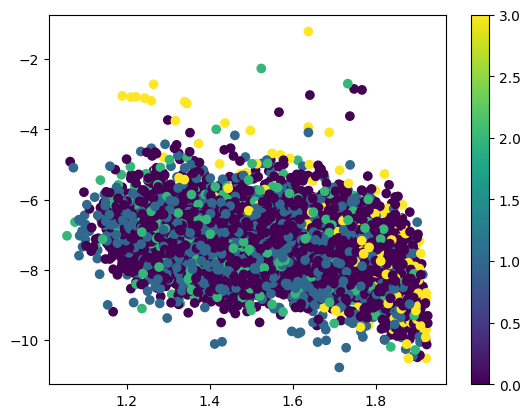

In [23]:
# Compare the power ranges

scatter = plt.scatter(dataset["low_freq_power"], np.log(dataset["high_freq_power"]), c=dataset["class_index"], cmap="viridis")
plt.colorbar(scatter)
plt.show()